In [1]:
import numpy as np
import pandas as pd
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/provData/x_train.csv').set_index('Provider')

data.drop(columns = ['Unnamed: 0','Unnamed: 0.1'], inplace=True)

data.fillna(0, inplace=True)
data['LargeClaims'] = data['ClaimID'] > 1300

In [3]:
data_test = pd.read_csv('../data/provData/x_test.csv').set_index('Provider')
data_test.drop(columns = ['Unnamed: 0','Unnamed: 0.1'], inplace=True)
data_test.fillna(0, inplace=True)
data_test.head()

,Age,Gender,BeneID,ClaimID,NumDiag,InscClaimAmtReimbursed,OPAnnualReimbursementAmt,IPAnnualReimbursementAmt,TotalClaim,InscCovPercent,...,InscCovPercent_Range,DailyCharge_Range,docDegMax,docBtwnMean,docEignMean,docMANN,patDegMax,patBtwnMean,patEignMean,patMANN
Provider,,,,,,,,,,,,,,,,,,,,,
PRV51002,71.926829,71,169,205,2.878049,53790,2345.073171,5180.926829,264.243902,0.989728,...,0.777778,6010.0,9,105.477418,0.144884,2.466667,127,855.435281,0.149826,261.043080
PRV51006,74.343137,43,81,102,3.019608,30720,2401.666667,3767.549020,301.176471,1.000000,...,0.000000,2100.0,7,381.813986,0.002511,7.000000,92,196.902090,0.143410,76.771978
PRV51009,69.102564,16,30,39,3.256410,27230,2441.025641,3004.102564,729.948718,0.968461,...,0.666667,3300.0,2,98.000000,0.000856,14.500000,47,27.375165,0.089613,119.037313
PRV51010,74.815789,23,25,38,3.447368,64580,1775.789474,5268.421053,1840.000000,0.975097,...,0.262537,5068.0,5,1012.666667,0.000177,4.285714,39,76.288550,0.041593,109.133333
PRV51018,72.915789,66,146,190,2.868421,61620,2812.947368,4738.947368,327.842105,0.969389,...,1.000000,3300.0,5,56.532737,0.089660,11.000000,116,290.838499,0.203971,102.975788


In [4]:
data.Status

AttributeError: 'DataFrame' object has no attribute 'Status'

In [4]:
data.groupby('PotentialFraud')['fraudulence'].sum()

PotentialFraud
0    4097
1     464
Name: fraudulence, dtype: int64

In [5]:
print(data.query('PotentialFraud==1 & fraudulence==1').shape)
print(data.query('PotentialFraud==1 & fraudulence==0').shape)
print(data.query('PotentialFraud==0 & fraudulence==0').shape)
print(data.query('PotentialFraud==0 & fraudulence==1').shape)

(464, 49)
(42, 49)
(807, 49)
(4097, 49)


In [6]:
data.shape

(5410, 49)

In [7]:
464/5410

0.08576709796672828

## Metrics

### Recall
Recall (or sensitivity or true positive rate) is the fraction of observations having a true class of 1 (potentially fraudulent) that are being correctly classified as such. Recall is exactly how many of the fradulent providers we are actually classifying as fraudulent.

If we have a problem like cancer detection, we would ideally want our system to have very high recall, potentially at the expense of false postives or accuracy in general.

### F1 Score
F1 score is the harmonic mean of recall and precision, and it can be thought of as a balance of the two. While accuracy also serves this purpose, it can be quite misleading if classes are heavily imbalanced. In our case, only 9% of providers have been labeled as fraudulent and we assume the test set follows the same distribution. 

For instance, suppose we have a population of 1000 providers and 100 of them are fraudulent. We have a classfication system that produces the following results:

- 40 True Positive (correctly identified fraud)
- 10 False Positives (incorrectly mistook non-fraud for fraud)
- 20 False Negative (failed to identify fraud)
- 930 True Negatives (correctly identified non-fraud)

In this example, we have 93.0% accuracy while the F1 score is 72.7% (and 80% precision, 67% recall), which seems to be a more useful overall indicator of performance in this case.

### ROC Curve and AUC
The receiver operating characteristic curve (or ROC curve) is another tool for evaluating the classfication performance of different models. For any given model, the ROC curve plots the tradoff between the false positive rate on the x-axis against the true positive rate (aka Precision) for different choices of thresholds for a binary classifier. In one extreme case, if the classification threshold is 0, then all instances (for non-perfect models) will be classified as 0, leading to a false positive rate of 0, but also a true postive rate of 0. In the other extreme case, a threshold of 1 leads to a true positive rate/recall of 1 but also a false postive rate of 1. 

In terms of evaluating classification performance, an ROC curve which is closer to the (FPR = 0, TPR = 1) point compared to another indicates that the former model strictly dominates the latter. Beyond just the curve, one summary measure is simply the AUC or (A)rea (U)nder the ROC (C)urve. A completely random model will produce an AUC of 0.5 while a perfect model will have an AUC of 1.

In [22]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd
from scipy import stats


import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def confusion(x,y,model):
    confusion_matrix(y,model.predict(x))
    print_cm(confusion_matrix, labels = ['NoFraud','Fraud'])
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()


def feature_importance(model, columns, name, note):
    coefs = pd.DataFrame(np.dstack((
        columns,model.named_steps[name].coef_.round(4)))[0], 
                         columns = ['Features','Coefficients']).\
    sort_values('Coefficients',ascending=True).set_index('Features')
    
    coefs.plot(kind='barh', figsize=(9,7))
    plt.title(name + ' ' + note)
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    #print(coefs)


def logitMetrics(x,y, model):
    logit_tr_acc = model.score(x, y)
    logit_tr_pr, logit_tr_re, logit_tr_f1, _ = precision_recall_fscore_support(y, model.predict(x))

    print(" Logit Train Accuracy : %1.3f" % (logit_tr_acc))
    print(" Logit Train Precision: %1.3f (no fraud) and %1.3f (fraud)" % (logit_tr_pr[0], logit_tr_pr[1]))
    print(" Logit Train Recall   : %1.3f (no fraud) and %1.3f (fraud)" % (logit_tr_re[0], logit_tr_re[1]))
    print(" Logit Train F1 Score : %1.3f (no fraud) and %1.3f (fraud)" % (logit_tr_f1[0], logit_tr_f1[1]))
    
def ROC(x,y, model):
    y_probs_logit = pd.DataFrame(model.predict_proba(x))[1]
    fpr, tpr, thresholds = roc_curve(y, y_probs_logit)
    auc = roc_auc_score(y, y_probs_logit)  # Computes auc
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw,
            label='ROC logit (area = %0.2f)' % auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0, 1.02])
    plt.ylim([0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Curve')
    plt.legend(loc="lower right")
    plt.show()

## Ridge Pipeline

## Check Performance

In [9]:
y = data['PotentialFraud']
X = data.drop(columns = ['Age',
                         'State_in',
                         'Gender',
                         'docEignMean',
                         'patEignMean',
                         'Alzheimer', 
                         'HeartFailure',
                         'OPAnnualReimbursementAmt',
                         'IPAnnualReimbursementAmt',
                         'Cancer', 
                         'ObstrPulmonary', 
                         'Diabetes',
                         'Osteoporasis',
#                          'patBtwnMean',
#                          'NumProc_Range',
#                          'patMANN',
#                          'KidneyDisease',
                         'IschemicHeart',
                         'Depression',
                         'WhetherDead',
                         'RheumatoidArthritis', 
                         'Stroke',
                         'NumDiag',
                         'fraudulence',
                         'DupRecord',
                         'ClaimDays_in',
#                          'docDegMax',
#                          'NumChronics_in',
                         'PotentialFraud',
#                          'ClaimID',
                         'TotalClaim_Range',
                         'NumChronics_out',
                         'NumProc_in',
                         'docMANN',
#                          'DailyCharge_Range',
                         'patDegMax',
                         'DailyCharge',
                         'ClaimDays_Range',
#                          'docBtwnMean',
#                          'TotalClaim',
#                          'InscCovPercent_Range',
#                          'State_out',
                         'ClaimDays_out',
                         'NumProc_out',
                         'AdmissionDays_in'])

In [10]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as tts

def two_stage_model_predict(X,y):
    
    ## Stage 1 Classifier
    name = 'LogReg'

    X_train, X_test, y_train, y_test = tts(X, y,random_state=0, test_size = 1.0/3)

    steps = [('scaler', StandardScaler()),
             (name, LogisticRegression())]

    model_stage1 = Pipeline(steps = steps)
    _ = model_stage1.fit(X_train,y_train)
    
    coefs_1 = pd.DataFrame(np.dstack((
        X.columns,model_stage1.named_steps[name].coef_.round(4),model_stage1['scaler'].scale_))[0], 
                         columns = ['Features','Coefficients_1','Scale_1']).\
    sort_values('Coefficients_1',ascending=True).set_index('Features')

    ## Stage 2 Classifier
    y_pred1 = model_stage1.predict(X)

    stage1 = pd.DataFrame({'Target' : y, 'Prediction' : y_pred1})

    y_correct1 = stage1.query('Target == Prediction')[['Prediction']]

    y_2 = stage1.query('Target != Prediction')['Target']
    
    idx1 = y_1.index
    idx2 = y_2.index
    X_1 = data.loc[idx1,:]
    X_2 = data.loc[idx2,:]

    X_train2, X_test2, y_train2, y_test2 = tts(X_2, y_2,random_state=0, test_size = 1.0/3)

    steps = [('scaler', StandardScaler()),
             (name, LogisticRegression())]

    model_stage2 = Pipeline(steps = steps)
    _ = model_stage2.fit(X_train2,y_train2)
    
    coefs_2 = pd.DataFrame(np.dstack((
        X_2.columns,model_stage2[name].coef_.round(4),model_stage2['scaler'].scale_))[0], 
                         columns = ['Features','Coefficients_2','Scale_2']).\
    sort_values('Coefficients_2',ascending=True).set_index('Features')

    y_pred2 = model_stage2.predict(X_2)

    stage2 = pd.DataFrame({'Target' : y_2, 'Prediction' : y_pred2})

    y_correct2 = stage2.query('Target == Prediction')[['Prediction']]

    y_pred = y_correct1.append(y_correct2)
    
    coefs = pd.merge(coefs_1,coefs_2, on='Features').reset_index()
    # Sort the index after the append to get all the ducks in a row
    return y_pred.sort_index(), coefs

In [ ]:
coefs['Rescaled_Coef_1'] = coefs['Coefficients_1']/coefs['Scale_1']
coefs['Rescaled_Coef_2'] = coefs['Coefficients_2']/coefs['Scale_2']
coefs['First'] = coefs['Rescaled_Coef_1'].apply(lambda x: np.exp(x)-1)
coefs['Second'] = coefs['Rescaled_Coef_2'].apply(lambda x: np.exp(x)-1)

coefs

In [ ]:
df = coefs.melt(value_vars = ['First','Second'], 
           id_vars = 'Features', 
           value_name = 'IncreaseInOdds', 
           var_name = 'Stage').sort_values('IncreaseInOdds',ascending=False)

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.barplot(y = 'Features',x = 'IncreaseInOdds', hue = 'Stage', data=df)
plt.xscale('log')
plt.tight_layout()
ax.set_ylabel('')
ax.set_xlabel('Increase in Odds (%)')

In [ ]:
confusion_matrix(y,y_pred)


In [ ]:
model_stage1[name].coef_

In [ ]:
y = data['PotentialFraud']
X = data[['fraudulence','ClaimID','LargeClaims','DailyCharge_Range','NumProc_in','docMANN',]]

X_train, X_test, y_train, y_test = tts(X, y,random_state=2, test_size = 1.0/5)
logit = LogisticRegression().fit(X_train,y_train)


logitMetrics(X_test,y_test,logit)
print(confusion_matrix(y_test, logit.predict(X_test)))
ROC(X_test,y_test,logit)


#feature_importance(logit, X.columns, name, 'Recall')


In [ ]:
y = data['PotentialFraud']
X = data.drop(columns = [
    'PotentialFraud',
    'Age',
    'State_in',
    'Gender',
    'docEignMean',
#     'patEignMean',
    'patDegMax',
    'Alzheimer', 
    'HeartFailure',
    'OPAnnualReimbursementAmt',
    'IPAnnualReimbursementAmt',
    'Cancer', 
    'ObstrPulmonary', 
    'Diabetes',
    'Osteoporasis',
    'Depression',
    'patBtwnMean',
#     'NumProc_Range',
#     'patMANN',
#     'KidneyDisease',
#     'IschemicHeart',
#     'WhetherDead',
    'RheumatoidArthritis',
    'InscCovPercent',
    'Stroke',
#     'fraudulence',
    'docDegMax',
#     'NumChronics_in',
#     'TotalClaim_Range',
#     'NumChronics_out',
    'NumProc_in',
    'docMANN',
#     'docBtwnMean',
    'State_out',
#     'ClaimDays_out',
#     'LargeClaims',
#     'NumProc_out',
    'AdmissionDays_in',
    'BeneID',
])

## Stage 1 Model Build

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split as tts

name = 'LogReg_Stage1'
over = BorderlineSMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)

X_train, X_test, y_train, y_test = tts(X, y,random_state=2, test_size = 1.0/5)
X_train1, X_test1, y_train1, y_test1 = tts(X_train, y_train,random_state=6, test_size = 1.0/3)

steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         (name, LogisticRegressionCV(
             Cs = np.logspace(-6,1,20),penalty='l1',
             scoring = 'recall',
             class_weight = 'balanced',
             solver='liblinear',
             max_iter=1000))]

model_stage1 = Pipeline(steps = steps)
_ = model_stage1.fit(X_train1,y_train1)

logitMetrics(X_test1,y_test1,model_stage1)
print(confusion_matrix(y_test1,model_stage1.predict(X_test1)))
ROC(X_test1,y_test1,model_stage1)


feature_importance(model_stage1, X.columns, name, 'Recall')

## Stage 1 Model Evaluation

In [ ]:
logitMetrics(X_train,y_train,model_stage1)
cm = confusion_matrix(y_train,model_stage1.predict(X_train))
tn1,fp1,fn1,tp1 = cm.ravel()
print(cm)
ROC(X_train,y_train,model_stage1)

## Subset Data for Stage 2

In [ ]:
y_pred1 = pd.DataFrame({'Prediction' : model_stage1.predict(X_train)}, index = y_train.index)
idx1 = y_pred1.query('Prediction==0')["Prediction"].index
y_1noFN = y.loc[idx1]
idx2 = y_pred1.query('Prediction==1')["Prediction"].index
#idx2 = y.index
X_2 = X.loc[idx2,:]
#X_2['LargeClaims'].value_counts()
y_2 = y.loc[idx2]

In [ ]:
X_2.columns

In [ ]:
X_2.drop(columns = [
#     'ClaimID', 
#     'NumDiag', 
    'TotalClaim', 
#     'DailyCharge',
    'DupRecord', 
    'fraudulence', 
#     'ClaimDays_in',
    'NumChronics_in',
    'NumChronics_out', 
    'fraudulence',
#     'NumProc_Range', 
#     'ClaimDays_Range',
#     'TotalClaim_Range', 
#     'InscCovPercent_Range', 
#     'DailyCharge_Range'
],inplace=True)

## Stage 2 Model Building

In [ ]:
name = 'LogReg_Stage2'
X_train2, X_test2, y_train2, y_test2 = tts(X_2, y_2,random_state=7, test_size = 1.0/3)

over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.7)


steps = [('scaler', StandardScaler()),
         ('o', over),
         ('u', under),
         (name, LogisticRegressionCV(
             Cs = np.logspace(-3,2,20),penalty='l2',
             scoring = 'recall_weighted',
             class_weight = 'balanced',
             solver='liblinear',
             max_iter=1000))]

model_stage2 = Pipeline(steps = steps)
_ = model_stage2.fit(X_train2,y_train2)

logitMetrics(X_test2,y_test2,model_stage2)
print(confusion_matrix(y_test2,model_stage2.predict(X_test2)))
ROC(X_test2,y_test2,model_stage2)

feature_importance(model_stage2, X_2.columns, name, 'Recall')

## Stage 2 Model Evaluation

In [ ]:
logitMetrics(X_2,y_2,model_stage2)
cm2 = confusion_matrix(y_2,model_stage2.predict(X_2))
tn2,fp2,fn2,tp2 = cm2.ravel()
print(cm2)
ROC(X_2,y_2,model_stage2)

y_pred2 = pd.DataFrame({'Prediction' : model_stage2.predict(X_2)}, index = y_2.index)


In [ ]:
y_pred2

## Print out of Sizes

In [ ]:
print('Full Train Target Size: \t\t{}'.format(y.shape))
print('Size for Final Model Evaluation: \t{}'.format(y_test.shape))


print('\nSize of Target Subset 1st Stage: \t{}'.format(y_train.shape))
print('\nSize for 1st Stage Training: \t\t\t{}'.format(y_train1.shape))
print('Size for 1st Stage Evaluation: \t\t\t{}'.format(y_test1.shape))


print('\nSize withheld from 2nd Stage: \t\t{}'.format(y_1noFP.shape))
print('Size of Target Subset 2nd Stage: \t{}'.format(y_2.shape))
print('\nSize for 2nd Stage Training: \t\t\t{}'.format(y_train2.shape))
print('Size for 2nd Stage Evaluation: \t\t\t{}'.format(y_test2.shape))

In [ ]:

y_pred2 = pd.DataFrame({'Prediction' : model_stage2.predict(X_2)}, 
                       index = y_2.index)

# cm2 = confusion_matrix(y_2, y_pred2['Prediction'])
# tn2,fp2,fn2,tp2 = cm2.ravel()

final_prediction = y_1noFP.append(y_pred2['Prediction']).sort_index()

In [ ]:
final_prediction

In [ ]:
df_ = pd.DataFrame({'Prediction1' : model_stage1.predict(X_train),
              'Prediction2' : final_prediction}, 
                           index = y_train.index)
df_['and'] = df_['Prediction1'] & df_['Prediction2']
df_

In [ ]:
df = pd.DataFrame({'Prediction1' : model_stage1.predict(X_train),
              'Prediction2' : model_stage2.predict(X_train)}, 
                           index = y_train.index)
df['and'] = df['Prediction1'] & df['Prediction2']
df

In [ ]:
print(confusion_matrix(y_train,df['and']))

logit_tr_pr, logit_tr_re, logit_tr_f1, _ = precision_recall_fscore_support(y_train, df['and'])

print(" Logit Train Precision: %1.3f (no fraud) and %1.3f (fraud)" % (logit_tr_pr[0], logit_tr_pr[1]))
print(" Logit Train Recall   : %1.3f (no fraud) and %1.3f (fraud)" % (logit_tr_re[0], logit_tr_re[1]))
print(" Logit Train F1 Score : %1.3f (no fraud) and %1.3f (fraud)" % (logit_tr_f1[0], logit_tr_f1[1]))

In [ ]:
x = 5


In [41]:
def cost_model(y, y_pred):
    reimbursement = data.loc[y.index,'InscClaimAmtReimbursed']
    df = pd.DataFrame(
        {
            'actual':y,
            'prediction':y_pred,
            'reimbursement': reimbursement # total amounts per provider
        }
    )
    cost_of_investigation = 100000
    print(confusion_matrix(y, y_pred))
    
    totalclaims =      np.sum(df['reimbursement'])
    totaldefrauded =   np.sum(df.query('actual==1')['reimbursement'])
    
    totalcost =     np.sum(df.query('prediction==1')['prediction'])*cost_of_investigation
    totalfalsepos =    np.sum(df.query('prediction==1 & actual==0')['prediction'])*cost_of_investigation
    totalrecovered =   np.sum(df.query('prediction==1 & actual==1')['reimbursement'])
    
    pct_fraud = 100*totaldefrauded/totalclaims
    
    print('Total Claims are ${:,.0f}'.format(totalclaims))
    print('Percentage of claims associated with fraudulent providers are {:.2f} of total claims'.format(pct_fraud))
    print('Cost to insurer at 100K per provider investigation ${:,.0f}'.format(totalcost))
    print('Total legal costs for investigating non-fradulent providers are %i' %100*totalfalsepos/totalcost,'% of total cost')
    print('Total Recovered claims are %i' %100*totalrecovered/totaldefrauded,'% of total claims')
    print('Net benefit of model as Pct of total claims is %i' %(totalrecovered/(totalcost + totalfalsepos)),'% of total claims')

In [ ]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split as tts

def two_stage_model_predict(X,y):
    
    ## Stage 1 Classifier
    name = 'LogReg_Stage1'

    #X_train, X_test, y_train, y_test = tts(X, y,random_state=0, test_size = 1.0/3)

    steps = [('scaler', StandardScaler()),
             (name, LogisticRegressionCV(
                 Cs = [1e-4],
                 penalty='l2',
                 scoring = 'recall',
                 class_weight = 'balanced',
                 solver='liblinear',
                 max_iter=1000))]

    model_stage1 = Pipeline(steps = steps)
    _ = model_stage1.fit(X,y)
    
#     coefs_1 = pd.DataFrame(np.dstack((
#         X.columns,model_stage1.named_steps[name].coef_.round(4),model_stage1['scaler'].scale_))[0], 
#                          columns = ['Features','Coefficients_1','Scale_1']).\
#     sort_values('Coefficients_1',ascending=True).set_index('Features')

    ## Confusion Matrix
#     cm = confusion_matrix(y_train,model_stage1.predict(X_train))
#     tn1,fp1,fn1,tp1 = cm.ravel()

    ## Stage 2 Classifier
    
    ## Subset data for Stage 2 (Take out all TN and FP)
    
    y_pred1 = model_stage1.predict(X)
    
    #leave_out = y_pred1.query('Prediction==0')["Prediction"].index
    #to_2nd_stage = y_pred1.query('Prediction==1')["Prediction"].index
    
    y_1noFN = y.loc[y_pred1 == 0]
    X_2 = X.loc[y_pred1 == 1,:]
    y_2 = y.loc[y_pred1 == 1]
    
    ## Stage 2 Model Building
    
    name = 'LogReg_Stage2'
    
#     X_train2, X_test2, y_train2, y_test2 = tts(X_2, y_2,random_state=7, 
#                                                test_size = 1.0/3)

#     over = BorderlineSMOTE(sampling_strategy=0.4)
#     under = RandomUnderSampler(sampling_strategy=0.7)


    steps = [#('scaler', StandardScaler()),
             #('o', over),
             #('u', under),
             (name, LogisticRegressionCV(
                 Cs = np.logspace(-3,2,20),penalty='l2',
                 scoring = 'f1',
                 class_weight = 'balanced',
                 solver='liblinear',
                 max_iter=1000))]

    model_stage2 = Pipeline(steps = steps)
    _ = model_stage2.fit(X_2,y_2)

    
#     coefs_2 = pd.DataFrame(np.dstack((
#         X_2.columns,model_stage2[name].coef_.round(4),model_stage2['scaler'].scale_))[0], 
#                          columns = ['Features','Coefficients_2','Scale_2']).\
#     sort_values('Coefficients_2',ascending=True).set_index('Features')


#     y_pred2 = pd.DataFrame({'Prediction' : model_stage2.predict(X_2)}, 
#                            index = y_2.index)
    
#     cm2 = confusion_matrix(y_2, y_pred2['Prediction'])
#     tn2,fp2,fn2,tp2 = cm2.ravel()
    
#     final_prediction = y_1noFP.append(y_pred2['Prediction']).sort_index()

#     cmf = confusion_matrix(y_train,final_prediction)
#     tnf,fpf,fnf,tpf = cmf.ravel()
    
#     print(tn1,fp1,fn1,tp1,sum([tn1,fp1,fn1,tp1]))
#     print(tn2,fp2,fn2,tp2,sum([tn2,fp2,fn2,tp2]))


#     print(tnf,fpf,fnf,tpf,sum([tnf,fpf,fnf,tpf]))
    
    df = pd.DataFrame({'Prediction1' : model_stage1.predict(X_train),
              'Prediction2' : model_stage2.predict(X_train)}, 
                           index = y_train.index)
    df['and'] = df['Prediction1'] & df['Prediction2']



#     print(cmf)
    return df['and']

In [ ]:

from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold


print(__doc__)

X_train, X_test, y_train, y_test = tts(X, y,random_state=2)

#anova_filter = SelectKBest(f_regression, k=10)

name = 'LogRegRecall'
over = BorderlineSMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.7)

steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         #('anova',anova_filter),
         (name, LogisticRegressionCV(
             Cs = np.logspace(-5,1,20),
                     penalty='l1',
                     scoring = 'f1',
                     class_weight = 'balanced',
                     solver='liblinear',
                     max_iter=1000))]



model = Pipeline(steps = steps)
_ = model.fit(X_train,y_train)


logitMetrics(X_test,y_test,model)
ROC(X_test,y_test,model)

confusion(X_test,y_test,model)


feature_importance(model,name,'Ridge Regularization, Normalized Variables')

In [ ]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

name = 'Ridge_Classifier_Recall'
over = BorderlineSMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.8)

steps = [#('o', over),
         #('u', under),
         (name, RidgeClassifierCV(alphas = np.logspace(-2,2,10),
                                class_weight='balanced',
                                scoring = 'f1_weighted',
                                store_cv_values = True))]


model = Pipeline(steps = steps)
_ = model.fit(x_train,y_train)

logitMetrics(x_test,y_test,model);
cost_model(x_train,y_train,model);
print()
cost_model(x_test,y_test,model);
#feature_importance(model,name,'Ridge Regularization, Normalized Variables')


In [ ]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Define preprocessor
scaler = StandardScaler()

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logit = LogisticRegression(max_iter=10000, tol=0.1, 
                           solver = 'liblinear', random_state = 2)
cachedir = mkdtemp()

pipe = Pipeline(steps=[
    ('scaler', scaler), 
    ('pca', pca), 
    ('logit', logit)], memory = cachedir)

grid_params = {
    'logit__C': np.logspace(-4,4,10),
    'logit__penalty': ['l1','l2'],
    'pca__n_components': [5, 15, 30, 45, 64],
    
}

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

cv = GridSearchCV(
    pipe,
    grid_params,
    cv = rskf,
    scoring = ['f1_weighted'],
    refit = False,
    n_jobs = -1
)

x_train, x_test, y_train, y_test = ms.train_test_split(x,y, 
                                                       test_size=1.0/3, random_state=0)

cv.fit(x_train,y_train)


## Best Recall (No false Negatives)

In [80]:
y = data['PotentialFraud']
X = data.drop(columns = [
    'PotentialFraud',
    'Age',
    'State_in',
    'Gender',
    'docEignMean',
#     'patEignMean',
    'patDegMax',
    'Alzheimer', 
    'InscClaimAmtReimbursed',
    'HeartFailure',
    'OPAnnualReimbursementAmt',
    'IPAnnualReimbursementAmt',
    'Cancer', 
    'ObstrPulmonary', 
    'Diabetes',
    'Osteoporasis',
    'Depression',
    'patBtwnMean',
#     'NumProc_Range',
    'patMANN',
#     'KidneyDisease',
#     'IschemicHeart',
#     'WhetherDead',
    'RheumatoidArthritis',
    'InscCovPercent',
    'Stroke',
    'fraudulence',
    'docDegMax',
#     'NumChronics_in',
#     'TotalClaim_Range',
#     'NumChronics_out',
    'NumProc_in',
    'docMANN',
#     'docBtwnMean',
    'State_out',
#     'ClaimDays_out',
#     'LargeClaims',
#     'NumProc_out',
    'AdmissionDays_in',
    'BeneID',
])

#X.drop(labels = idx, axis=0, inplace=True)
#y.drop(labels = idx, axis=0, inplace=True)

In [81]:
y.shape

(5410,)

In [50]:

from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from joblib import Memory
from shutil import rmtree

# # Create a temporary folder to store the transformers of the pipeline
# location = 'cachedir'

# memory = Memory(location=location, verbose=10)

name = 'logreg'

X_train, X_test, y_train, y_test = tts(X, y,random_state=0, test_size=1.0/3)

#anova_filter = SelectKBest(f_regression, k =4)

mutual_info_filter = SelectKBest(mutual_info_classif, k = 5)

param_grid = dict(
    logreg__penalty = ['l1','l2'],
    logreg__C = np.logspace(-4,1,15),
    #o__sampling_strategy = np.linspace(0.1,0.5,5),
    #logreg__l1_ratio = np.linspace(0,1,10),
)
                  

steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         #('anova', anova_filter),
         #('mInfo', mutual_info_filter),
         (name, LogisticRegression(
                 #C = 1e-4,
                 class_weight='balanced',
                 solver = 'liblinear',
             ))]

model = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

search = GridSearchCV(model, 
                      cv =cv,
                      param_grid=param_grid,
                      scoring = 'recall').fit(X_train,y_train)

#_ = model.fit(X_train,y_train)


#print(model_.best_params_)

NameError: name 'RepeatedStratifiedKFold' is not defined

In [51]:
model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])>

In [52]:
model = search.best_estimator_
y_pred = model.predict(X_test)
logitMetrics(X_test,y_test,model);
print(confusion_matrix(y_test, y_pred))
ROC(X_test,y_test,model)
cost_model(y_test, y_pred)

NameError: name 'search' is not defined

In [53]:
pd.DataFrame({'Features' : X.columns,
              'Mutual_Info' : model.named_steps['mInfo'].scores_}).sort_values('Mutual_Info',ascending=False)

KeyError: 'mInfo'

In [55]:
def cost_model(y, y_pred):
    reimbursement = data.loc[y.index,'InscClaimAmtReimbursed']
    df = pd.DataFrame(
        {
            'actual':y,
            'prediction':y_pred,
            'reimbursement': reimbursement # total amounts per provider
        }
    )
    cost_of_investigation = 100000
    print(confusion_matrix(y, y_pred))

    totalclaims =      np.sum(df['reimbursement'])
    totaldefrauded =   np.sum(df.query('actual==1')['reimbursement'])

    totalcost =        np.sum(df.query('prediction==1')['prediction'])*cost_of_investigation
    totalfalsepos =    np.sum(df.query('prediction==1 & actual==0')['prediction'])*cost_of_investigation
    totalrecovered =   np.sum(df.query('prediction==1 & actual==1')['reimbursement'])

    pct_fraud = totaldefrauded/totalclaims
    falsepos_pct = totalfalsepos/totalcost
    recov_pct = totalrecovered/totaldefrauded
    net_benefit_pct = totalrecovered/(totalcost + totalfalsepos)

    print('Total Claims are ${:,.0f}'.format(totalclaims))
    print('Percentage of total reimbursements associated with fraudulent providers is {:.0%}'.format(pct_fraud))
    print('Cost to insurer at 100K per provider investigation ${:,.0f}'.format(totalcost))
    print('Total legal costs for investigating non-fradulent providers are {:.0%} of total cost'.format(falsepos_pct))
    print('Total Recovered claims are {:.0%} of total defrauded claims'.format(recov_pct))
    print('Net benefit of model as Pct of total claims is {:.0%} of total claims'.format(net_benefit_pct))

## AdaBoostClassifier

In [82]:
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier

name = 'AdaBoost'

X_train, X_test, y_train, y_test = tts(X, y,random_state=4, test_size=1.0/3)

#anova_filter = SelectKBest(f_regression, k =4)

mutual_info_filter = SelectKBest(mutual_info_classif, k = 5)

param_grid = dict(
    #ada__n_estimators = range(100,401,100),
    #ada__learning_rate = np.linspace(0.2,1.5,10),
    #ada__random_state = range(0,5)
)

steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         #('anova', anova_filter),
         #('mInfo', mutual_info_filter),
         (name, AdaBoostClassifier(
             n_estimators = 100,
             random_state = 0,
             learning_rate = 0.2
         ))]

model = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

search = GridSearchCV(model, 
                      param_grid=param_grid,
                      cv = cv,
                      scoring = 'f1').fit(X_train,y_train)

_ = model.fit(X_train,y_train)


# model = search.best_estimator_
#print(model_.best_params_)

In [83]:
model = search.best_estimator_

In [84]:
model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()),
                ('AdaBoost',
                 AdaBoostClassifier(learning_rate=0.2, n_estimators=100,
                                    random_state=0))])>

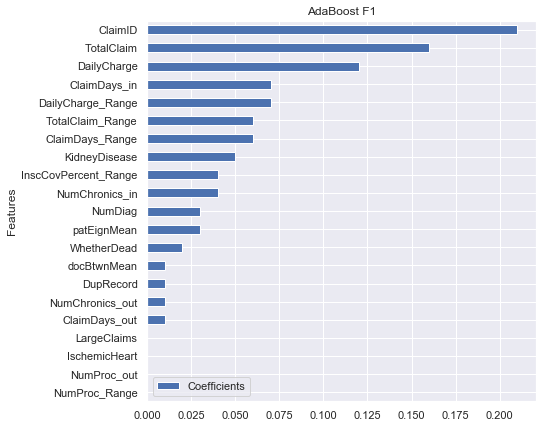

In [89]:
feature_importance(model, X.columns, 'AdaBoost', 'F1')

In [88]:
def feature_importance(model, columns, name, note):
    coefs = pd.DataFrame(np.dstack((
        columns,model.named_steps[name].feature_importances_.round(4)))[0], 
                         columns = ['Features','Coefficients']).\
    sort_values('Coefficients',ascending=True).set_index('Features')
    
    coefs.to_csv('../data/feature_importances_'+name)

    coefs.plot(kind='barh', figsize=(9,7))
    plt.title(name + ' ' + note)
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    
    
    #print(coefs)

 Logit Train Accuracy : 0.946
 Logit Train Precision: 0.967 (no fraud) and 0.721 (fraud)
 Logit Train Recall   : 0.974 (no fraud) and 0.669 (fraud)
 Logit Train F1 Score : 0.970 (no fraud) and 0.694 (fraud)
[[0.88414634 0.02383592]
 [0.0304878  0.06152993]]


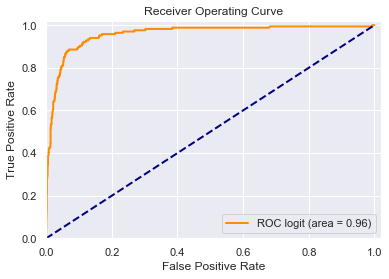

[[1595   43]
 [  55  111]]
Total Claims are $191,583,380
Percentage of total reimbursements associated with fraudulent providers is 52%
Cost to insurer at 100K per provider investigation $15,400,000
Total legal costs for investigating non-fradulent providers are 28% of total cost
Total Recovered claims are 90% of total defrauded claims
Net benefit of model as Pct of total claims is 454% of total claims


In [87]:

y_pred = model.predict(X_test)
logitMetrics(X_test,y_test,model);
cm =confusion_matrix(y_test, y_pred)
print(cm/sum(sum(cm)))
ROC(X_test,y_test,model)
cost_model(y_test, y_pred)

## MLP Classifier

In [91]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = tts(X, y,random_state=4, test_size=1.0/3)

#anova_filter = SelectKBest(f_regression, k =10)

param_grid = dict(#MLP__learning_rate_init = np.linspace(0.05,0.13,5),
                  #MLP__max_iter = range(500,1000,100)
                 )

                  

name = 'MLP'
steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         #('anova', anova_filter),
         (name, MLPClassifier(random_state=1,
                              alpha=0.1,
                              max_iter=500,
                              learning_rate_init=0.01,
                              learning_rate='adaptive'))]

model = Pipeline(steps = steps)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

search = GridSearchCV(model, 
                      cv = cv,
                      param_grid=param_grid,
                      scoring = 'f1').fit(X_train,y_train)

_ = model.fit(X_train,y_train)



model = search.best_estimator_

In [ ]:
model.get_params

In [92]:
feature_importance(model, X.columns, name, 'F1')

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [ ]:

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

In [ ]:

y_pred = model.predict(X_test)
logitMetrics(X_test,y_test,model);
cm =confusion_matrix(y_test, y_pred)
print(cm/sum(sum(cm)))
ROC(X_test,y_test,model)
cost_model(y_test, y_pred)

In [ ]:
df = pd.DataFrame(
        {
            'actual':y,
            'prediction':y_pred})

In [ ]:
idx = df.query('actual == 0 & prediction == 1').index
data.loc[idx,['State_out','BeneID', 'ClaimID', 'NumDiag','NumChronics_out','Diabetes','IschemicHeart','TotalClaim_Range','TotalClaim',
       'IPAnnualReimbursementAmt']]

In [ ]:
idx

## LogitBoost

In [84]:
from logitboost import LogitBoost

In [93]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = tts(X, y,random_state=0, test_size=1.0/3)
anova_filter = SelectKBest(f_regression, k =10)

param_grid = dict()
    #lboost__n_estimators = range(100,351,50),
    #lboost__learning_rate = np.logspace(-3,0,10))

                  

name = 'lboost'
steps = [('scaler', StandardScaler()),
         #('o', over),
         #('u', under),
         #('anova', anova_filter),
         (name, LogitBoost(
             n_estimators = 200,
             learning_rate=0.46415888336127775,
             random_state=0))]

model = Pipeline(steps = steps)


cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 2, random_state = 1)

search = GridSearchCV(model, 
                      param_grid=param_grid,
                      cv = cv,
                      scoring = 'f1').fit(X_train,y_train)

_ = model.fit(X_train,y_train)



model = search.best_estimator_

In [94]:
model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()),
                ('lboost',
                 LogitBoost(learning_rate=0.46415888336127775, n_estimators=200,
                            random_state=0))])>

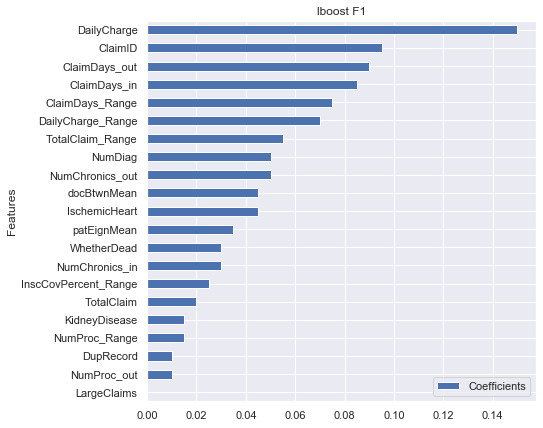

In [95]:
feature_importance(model, X.columns, name, 'F1')

 Logit Train Accuracy : 0.951
 Logit Train Precision: 0.965 (no fraud) and 0.787 (fraud)
 Logit Train Recall   : 0.982 (no fraud) and 0.657 (fraud)
 Logit Train F1 Score : 0.973 (no fraud) and 0.716 (fraud)
[[0.88968958 0.01662971]
 [0.03215078 0.06152993]]


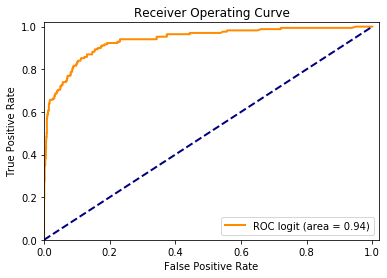

[[1605   30]
 [  58  111]]
Total Claims are $183,646,890
Percentage of total reimbursements associated with fraudulent providers is 53%
Cost to insurer at 100K per provider investigation $14,100,000
Total legal costs for investigating non-fradulent providers are 21% of total cost
Total Recovered claims are 92% of total defrauded claims
Net benefit of model as Pct of total claims is 521% of total claims


In [88]:

y_pred = model.predict(X_test)
logitMetrics(X_test,y_test,model);
cm =confusion_matrix(y_test, y_pred)
print(cm/sum(sum(cm)))
ROC(X_test,y_test,model)
cost_model(y_test, y_pred)

## Two Stage

In [28]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from logitboost import LogitBoost
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import warnings
from sklearn.model_selection import train_test_split as tts

warnings.simplefilter('ignore')

RANDOM_SEED = 42


X_train, X_test, y_train, y_test = tts(X, y,random_state=0, test_size=1.0/3)

clf3 = MLPClassifier(alpha=0.1, learning_rate='adaptive',
                               learning_rate_init=0.09, max_iter=500,
                               random_state=1)
clf2 = LogitBoost(
    n_estimators = 200,
    learning_rate=0.46415888336127775,
    random_state=0)
clf1 = AdaBoostClassifier(learning_rate=0.2, n_estimators=100,
                                    random_state=0)
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2],
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, sclf], 
                      ['MLP', 
                       'LogitBoost', 
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
    print("F1: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

F1: 0.62 (+/- 0.02) [MLP]
F1: 0.60 (+/- 0.02) [LogitBoost]
F1: 0.59 (+/- 0.02) [StackingClassifier]


In [59]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


RANDOM_SEED = 42


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_SEED)

clf1 = MLPClassifier(alpha=0.1, learning_rate='adaptive',
                               learning_rate_init=0.09, max_iter=500,
                               random_state=1)
clf2 = LogitBoost(
    n_estimators = 200,
    learning_rate=0.46415888336127775,
    random_state=0)
clf3 = AdaBoostClassifier(learning_rate=0.2, n_estimators=100,
                                    random_state=0)
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1],
                            #use_probas = True,
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)


# Learn to predict each class against the other
model = OneVsRestClassifier(sclf).fit(X_train,y_train)

In [62]:
model.predict(X_test).mean()

0.0016797312430011197

 Logit Train Accuracy : 0.903
 Logit Train Precision: 0.904 (no fraud) and 0.667 (fraud)
 Logit Train Recall   : 0.999 (no fraud) and 0.011 (fraud)
 Logit Train F1 Score : 0.949 (no fraud) and 0.023 (fraud)
[[9.02015677e-01 5.59910414e-04]
 [9.63045913e-02 1.11982083e-03]]


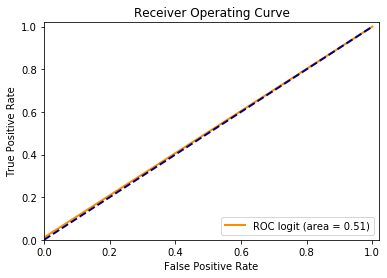

[[1611    1]
 [ 172    2]]
Total Claims are $171,723,370
Percentage of total reimbursements associated with fraudulent providers is 53%
Cost to insurer at 100K per provider investigation $300,000
Total legal costs for investigating non-fradulent providers are 33% of total cost
Total Recovered claims are 1% of total defrauded claims
Net benefit of model as Pct of total claims is 252% of total claims


In [63]:
# y_score = classifier.fit(X_train, y_train).predict_proba(X_test)


y_pred = model.predict(X_test)
logitMetrics(X_test,y_test,model);
cm =confusion_matrix(y_test, y_pred)
print(cm/sum(sum(cm)))
ROC(X_test,y_test,model)
cost_model(y_test, y_pred)

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plt.figure()
# lw = 2
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [64]:
data


,Age,Gender,BeneID,ClaimID,NumDiag,InscClaimAmtReimbursed,OPAnnualReimbursementAmt,IPAnnualReimbursementAmt,TotalClaim,InscCovPercent,...,DailyCharge_Range,PotentialFraud,docDegMax,docBtwnMean,docEignMean,docMANN,patDegMax,patBtwnMean,patEignMean,patMANN
Provider,,,,,,,,,,,,,,,,,,,,,
PRV51001,78.120000,9,24,25,3.640000,104640,2615.200000,17606.000000,4399.200000,0.975656,...,7403.60000,0,4,300.000000,1.160885e-03,8.000000,46,263.949347,0.060498,146.343750
PRV51003,69.553030,54,117,132,5.840909,605670,2678.181818,7568.181818,5090.575758,0.912167,...,29034.00000,1,1,0.000000,2.960140e-06,1.349206,89,621.197352,0.072514,117.974212
PRV51004,71.731544,46,138,149,2.771812,52170,2194.899329,4351.879195,352.214765,0.978485,...,3300.00000,0,4,36.851852,6.073016e-04,3.458333,110,196.289758,0.032412,264.349863
PRV51005,70.021459,511,495,1165,2.805150,280910,2109.733906,3623.991416,244.300429,0.980747,...,4080.00000,1,0,0.000000,2.927091e-05,0.000000,151,265.010514,0.268140,788.675936
PRV51007,68.763889,34,58,72,3.222222,33710,1729.722222,3050.000000,513.527778,0.985303,...,3300.00000,0,3,0.000000,5.432718e-03,4.750000,70,84.365494,0.100189,81.688948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRV57759,73.428571,16,24,28,2.178571,10640,3241.785714,3962.142857,384.642857,0.983401,...,2399.52381,0,0,0.000000,0.000000e+00,0.000000,44,179.669975,0.008937,253.902655
PRV57760,60.954545,17,9,22,2.681818,4770,1492.727273,2785.454545,216.818182,1.000000,...,1097.50000,0,2,0.666667,7.317151e-12,4.500000,9,29.717647,0.000225,80.450000
PRV57761,71.439024,40,67,82,2.890244,18470,2928.414634,7026.585366,229.756098,0.935979,...,1900.00000,0,2,0.000000,0.000000e+00,10.500000,175,1846.092411,0.038613,125.619753


In [67]:
data.columns

Index(['Age', 'Gender', 'BeneID', 'ClaimID', 'NumDiag',
       'InscClaimAmtReimbursed', 'OPAnnualReimbursementAmt',
       'IPAnnualReimbursementAmt', 'TotalClaim', 'InscCovPercent',
       'DailyCharge', 'DupRecord', 'fraudulence', 'WhetherDead', 'Alzheimer',
       'HeartFailure', 'KidneyDisease', 'Cancer', 'ObstrPulmonary',
       'Depression', 'Diabetes', 'IschemicHeart', 'Osteoporasis',
       'RheumatoidArthritis', 'Stroke', 'LargeClaims', 'AdmissionDays_in',
       'ClaimDays_in', 'ClaimDays_out', 'NumChronics_in', 'NumChronics_out',
       'NumProc_in', 'NumProc_out', 'State_in', 'State_out', 'NumProc_Range',
       'ClaimDays_Range', 'TotalClaim_Range', 'InscCovPercent_Range',
       'DailyCharge_Range', 'PotentialFraud', 'docDegMax', 'docBtwnMean',
       'docEignMean', 'docMANN', 'patDegMax', 'patBtwnMean', 'patEignMean',
       'patMANN'],
      dtype='object')

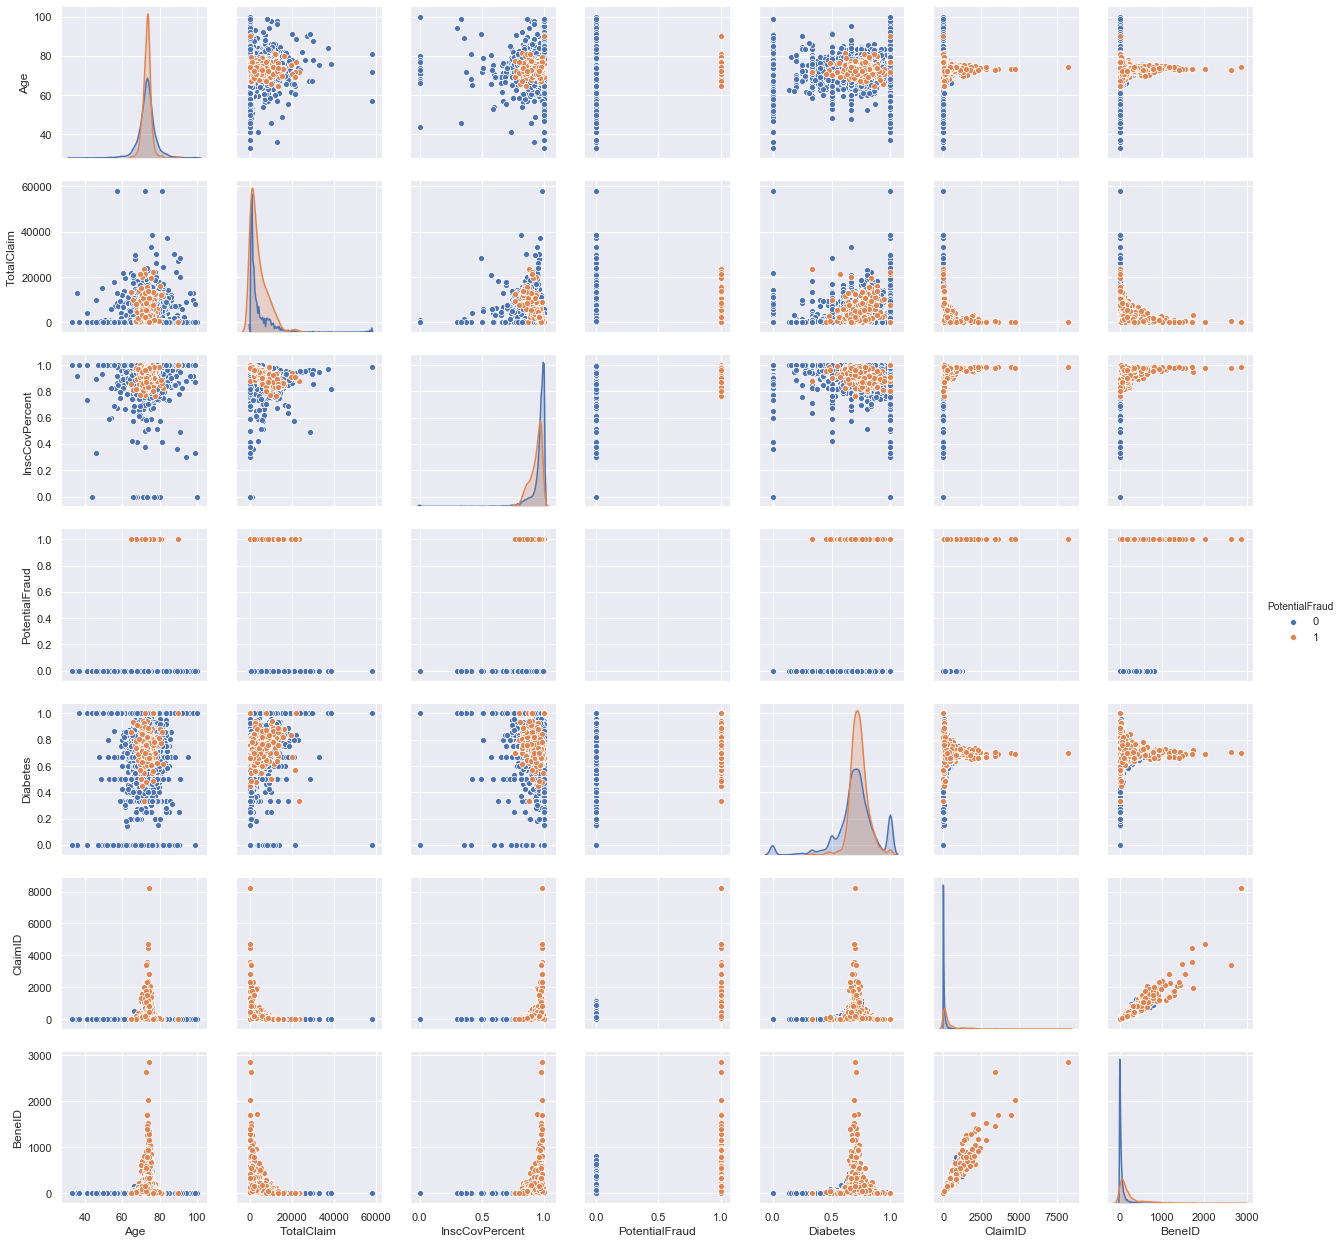

In [71]:
plt.style.use('ggplot')
import seaborn as sns
sns.set()

df = data[['Age','TotalClaim','InscCovPercent','PotentialFraud','Diabetes','ClaimID','BeneID']]
ax2 = sns.pairplot(df, hue="Diabetes");


#ax2.savefig("../visualizations/aiko/pairplot.png",bbox_inches='tight')